# Demo
### Foreign key: connect two column nodes

In [1]:
import sqlparse
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Function to parse SQL and extract table, fields, primary keys, and foreign keys
def parse_sql(sql):
    tables = {}
    foreign_keys = []

    # Split and process each CREATE TABLE statement
    statements = sqlparse.split(sql)
    for statement in statements:
        parsed = sqlparse.parse(statement)[0]
        tokens = [token for token in parsed.tokens if not token.is_whitespace]

        if 'CREATE TABLE' in statement.upper():
            table_name = None
            table_fields = []
            primary_key = None

            # Process each line in the create statement
            lines = statement.splitlines()
            for line in lines:
                line = line.strip()

                # Extract table name
                if line.upper().startswith('CREATE TABLE'):
                    table_name = line.split('"')[1]

                # Extract primary key
                elif 'PRIMARY KEY' in line.upper():
                    primary_key = line.split('"')[1]

                # Extract foreign keys
                elif 'FOREIGN KEY' in line.upper():
                    local_field = line.split('(')[1].split(')')[0].strip('"')
                    ref_table = line.split('REFERENCES')[1].split('(')[0].strip().strip('"')
                    ref_field = line.split('REFERENCES')[1].split('(')[1].split(')')[0].strip('"')
                    foreign_keys.append((table_name, local_field, ref_table, ref_field))

                # Extract other fields
                elif line and ('FOREIGN KEY' not in line) and ('PRIMARY KEY' not in line) and (not line.endswith(');')):
                    field_name = line.split()[0].strip('"')
                    table_fields.append(field_name)

            # Add the table and its fields to the tables dictionary
            if table_name:
                tables[table_name] = {
                    'fields': table_fields,
                    'primary_key': primary_key
                }

    return tables, foreign_keys

# Function to create a heterogeneous graph from parsed SQL
def create_heterogeneous_graph(tables, foreign_keys):
    G = nx.DiGraph()

    # Add nodes for each field in each table
    for table, data in tables.items():
        for field in data['fields']:
            node_id = f"{table}.{field}"
            G.add_node(node_id, label=field, table=table)

    # Add edges for foreign key relationships between columns (fields)
    for local_table, local_field, ref_table, ref_field in foreign_keys:
        local_node = f"{local_table}.{local_field}"
        ref_node = f"{ref_table}.{ref_field}"
        G.add_edge(local_node, ref_node, relation=f'FK({local_field} -> {ref_table}.{ref_field})')

    return G

# Function to visualize or process the heterogeneous graph
def display_graph_info(G):
    print("Nodes in the graph (columns):")
    for node in G.nodes(data=True):
        print(node)

    print("\nEdges in the graph (foreign key relationships):")
    for edge in G.edges(data=True):
        print(edge)


In [3]:
# Input SQL in test.sql for parsing
sql_input = ""
with open('test.sql', 'r', encoding='utf-8') as file:
    sql_input = file.read()

In [4]:
# Parse SQL and create heterogeneous graph
tables, foreign_keys = parse_sql(sql_input)
G = create_heterogeneous_graph(tables, foreign_keys)

# Display graph information
display_graph_info(G)

Nodes in the graph (columns):
('stadium.Stadium_ID', {'label': 'Stadium_ID', 'table': 'stadium'})
('stadium.Location', {'label': 'Location', 'table': 'stadium'})
('stadium.Name', {'label': 'Name', 'table': 'stadium'})
('stadium.Capacity', {'label': 'Capacity', 'table': 'stadium'})
('stadium.Highest', {'label': 'Highest', 'table': 'stadium'})
('stadium.Lowest', {'label': 'Lowest', 'table': 'stadium'})
('stadium.Average', {'label': 'Average', 'table': 'stadium'})
('singer.Singer_ID', {'label': 'Singer_ID', 'table': 'singer'})
('singer.Name', {'label': 'Name', 'table': 'singer'})
('singer.Country', {'label': 'Country', 'table': 'singer'})
('singer.Song_Name', {'label': 'Song_Name', 'table': 'singer'})
('singer.Song_release_year', {'label': 'Song_release_year', 'table': 'singer'})
('singer.Age', {'label': 'Age', 'table': 'singer'})
('singer.Is_male', {'label': 'Is_male', 'table': 'singer'})
('concert.concert_ID', {'label': 'concert_ID', 'table': 'concert'})
('concert.concert_Name', {'label

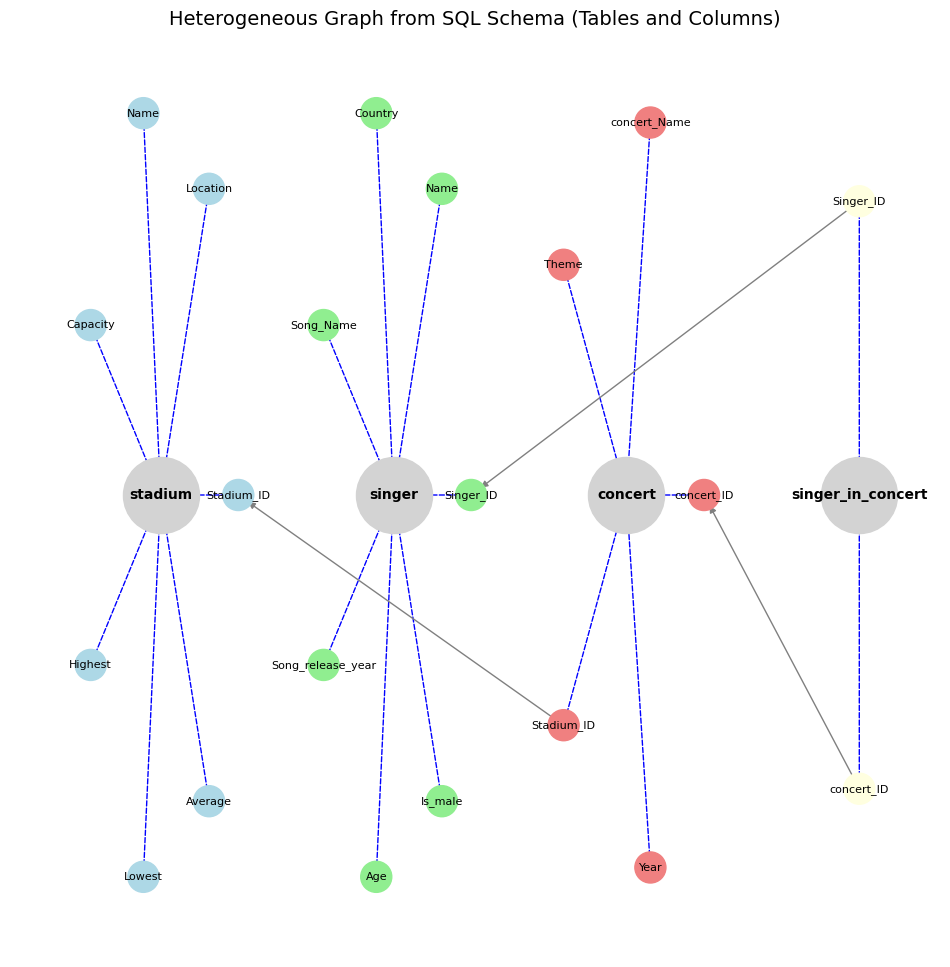

In [5]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# Function to visualize the graph (table and column)
def visualize_graph(G):
    plt.figure(figsize=(12, 12))

    # Get positions using spring layout
    pos = nx.spring_layout(G, seed=88)

    # Create a mapping for table colors
    table_colors = {
        "stadium": "lightblue",
        "singer": "lightgreen",
        "concert": "lightcoral",
        "singer_in_concert": "lightyellow"
    }

    # Separate nodes
    table_nodes = set()  # To keep track of unique table nodes
    column_nodes = []
    column_color_map = {}

    for node, data in G.nodes(data=True):
        table = data['table']
        if table not in table_nodes:
            table_nodes.add(table)  # Add table as a unique node
        column_nodes.append(node)  # Add each column (field) node
        column_color_map[node] = table_colors.get(table, 'lightgray')  # Assign color based on the table

    # Adjust positions: Place columns around their table
    for i, table in enumerate(table_nodes):
        table_pos = np.array([i * 3.0, 0])  # Position tables in a row
        pos[table] = table_pos  # Set table position

        # Find columns associated with the table and arrange them around the table node
        columns = [node for node in column_nodes if G.nodes[node]['table'] == table]
        num_columns = len(columns)
        
        if num_columns <= 2:
            # If there are 2 or fewer columns, arrange them vertically
            for j, column in enumerate(columns):
                column_pos = table_pos + np.array([0, (j - (num_columns - 1) / 2) * 1.5])  # Adjust y-position
                pos[column] = column_pos
        else:
            # Circular layout for more than 2 columns
            for j, column in enumerate(columns):
                angle = 2 * np.pi * j / num_columns  # Angle for circular layout around the table
                radius = 1.0  # Distance from table to column nodes
                column_pos = table_pos + np.array([radius * np.cos(angle), radius * np.sin(angle)])
                pos[column] = column_pos

    # Draw table nodes
    nx.draw_networkx_nodes(G, pos, nodelist=table_nodes, node_color='lightgray', node_size=3000, label='Tables')

    # Draw column nodes (fields) with assigned colors
    column_node_colors = [column_color_map[node] for node in column_nodes]
    nx.draw_networkx_nodes(G, pos, nodelist=column_nodes, 
                           node_color=column_node_colors, node_size=500, label='Columns')

    # Draw edges between table and column nodes
    edges_between_table_column = [(column, G.nodes[column]['table']) for column in column_nodes]
    nx.draw_networkx_edges(G, pos, edgelist=edges_between_table_column, edge_color='blue', style='dashed')

    # Draw edges between columns (foreign key relationships)
    nx.draw_networkx_edges(G, pos, edge_color='gray')

    # Draw labels for tables
    nx.draw_networkx_labels(G, pos, labels={node: node for node in table_nodes}, font_size=10, font_weight='bold')

    # Draw labels for fields (columns)
    column_labels = {node: node.split('.')[-1] for node in column_nodes}  # Only show the field name as label
    nx.draw_networkx_labels(G, pos, labels=column_labels, font_size=8, font_color='black')

    # Highlight primary key columns
    primary_keys = [node for node, data in G.nodes(data=True) if 'primary_key' in data and data['primary_key']]
    nx.draw_networkx_nodes(G, pos, nodelist=primary_keys, node_color='gold', node_size=700, label='Primary Keys')

    plt.title('Heterogeneous Graph from SQL Schema (Tables and Columns)', fontsize=14)
    plt.axis('off')  # Hide the axis
    plt.show()

# Visualize the graph
visualize_graph(G)
